# COVID19 DETECTION USING XRAYS

# Importing the required libraries :

In [2]:
import tensorflow as tf
import pandas as pd 
import random 
from imutils import paths 
from tensorflow.keras.applications import VGG16,VGG19 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import cv2
import os


# DATA Exploration :

The metadata.csv has the information about the data ie. data about data

In [4]:
covid_data = pd.read_csv('C:\\Users\\dhruv\\OneDrive\\Desktop\\New folder\\metadata.csv')
covid_data.head()


,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
covid_data[['finding','view','modality','location']]

,finding,view,modality,location
0,COVID-19,PA,X-ray,NaN
1,COVID-19,PA,X-ray,NaN
2,COVID-19,PA,X-ray,NaN
3,COVID-19,PA,X-ray,NaN
4,COVID-19,PA,X-ray,"Changhua Christian Hospital, Changhua City, Ta..."
...,...,...,...,...
141,COVID-19,AP Supine,X-ray,Italy
142,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
143,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
144,COVID-19,AP,X-ray,NaN


# Loading the image data :

Number of training images:  138


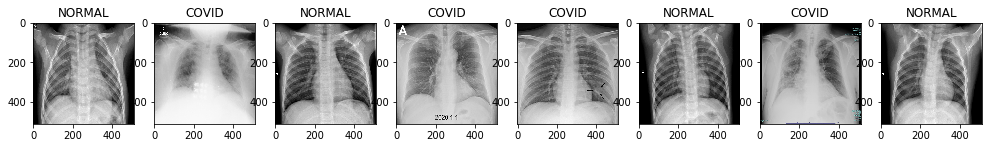

In [6]:
path_list = list(paths.list_images('C:\\Users\\dhruv\\OneDrive\\Desktop\\New folder\\COVID-19-Diagnosis-System-master\\dataset'))
X = []
Y = []


for path in path_list:
    # Set Class label
    y = path.split(os.path.sep)[-2]
    # Grayscale the image and reshape
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))

    # update the data and labels lists, respectively
    X.append(image)
    Y.append(y)

# Normalize images
X = np.array(X) / 255.0
Y = np.array(Y)

print('Number of training images: ', len(X))
# Plot example patient scan
W = 8
L = 1
fig, axes = plt.subplots(L, W, figsize = (17,17))
axes = axes.ravel() 
n = 138
for i in np.arange(0, W * L):
    index = np.random.randint(0, n)    
    axes[i].imshow( X[index] )
    axes[i].set_title(Y[index])


#one-hot encoding on the labels
lb = LabelBinarizer()
Y = lb.fit_transform(Y)
Y = tf.keras.utils.to_categorical(Y)



# Splitting the data set :

In [7]:
(X_train, x_test, Y_train, y_test) = train_test_split(X, Y,
	test_size=0.20, stratify=Y, random_state=2019)

(x_train, x_valid, y_train, y_valid) = train_test_split(X_train, Y_train,
	test_size=0.20, stratify=Y_train, random_state=2019)


# Data Augmentation :

In [8]:
Datagen= tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                            rotation_range=20,width_shift_range=0.2,
                            height_shift_range=0.2,horizontal_flip=True)

# Model Building :

In [9]:
def Covid_model():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG16(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model




# Model Training :


In [10]:
model= Covid_model()
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
covid= model.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),
                      steps_per_epoch=len(x_train) / 8,
                      validation_data=(x_valid, y_valid), epochs=100,callbacks = [early_stopping])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________

C:\Users\dhruv\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\dhruv\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\dhruv\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\dhruv\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\dhruv\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\dhruv\Anaconda3\lib\site-packages\keras_preprocessing

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
11/11 [==============================] - 243s 22s/step - loss: 1.0790 - acc: 0.5455 - val_loss: 0.6832 - val_acc: 0.5000
Epoch 2/100
11/11 [==============================] - 254s 23s/step - loss: 0.6291 - acc: 0.7500 - val_loss: 0.6383 - val_acc: 0.5909
Epoch 3/100
11/11 [==============================] - 226s 21s/step - loss: 0.6371 - acc: 0.7614 - val_loss: 0.5896 - val_acc: 0.6818
Epoch 4/100
11/11 [==============================] - 220s 20s/step - loss: 0.7667 - acc: 0.6591 - val_loss: 0.5984 - val_acc: 0.5909
Epoch 5/100
11/11 [==============================] - 220s 20s/step - loss: 0.3342 - acc: 0.8409 - val_loss: 0.5642 - val_acc: 0.5909
Epoch 6/100
11/11 [==============================] - 224s 20s/step - loss: 0.3820 - acc: 0.8409 - val_loss: 0.4766 - val_acc: 0.8636
Epoch 7/100
11/11 [==============================] - 219s 20s/step - loss: 0.4921 - acc: 0.8409 

11/11 [==============================] - 226s 21s/step - loss: 0.3235 - acc: 0.8636 - val_loss: 0.6663 - val_acc: 0.6818
Epoch 24/100
11/11 [==============================] - 217s 20s/step - loss: 0.2804 - acc: 0.8864 - val_loss: 0.4775 - val_acc: 0.7273
Epoch 25/100
11/11 [==============================] - 218s 20s/step - loss: 0.4655 - acc: 0.8409 - val_loss: 0.5471 - val_acc: 0.6818
Epoch 26/100
11/11 [==============================] - 220s 20s/step - loss: 0.1292 - acc: 0.9659 - val_loss: 0.3379 - val_acc: 0.7727
Epoch 27/100
11/11 [==============================] - 229s 21s/step - loss: 0.1903 - acc: 0.9318 - val_loss: 0.2181 - val_acc: 0.9091
Epoch 28/100
11/11 [==============================] - 225s 20s/step - loss: 0.6601 - acc: 0.8068 - val_loss: 0.1169 - val_acc: 1.0000
Epoch 29/100
11/11 [==============================] - 221s 20s/step - loss: 0.2508 - acc: 0.9205 - val_loss: 0.1607 - val_acc: 0.9091
Epoch 30/100
11/11 [==============================] - 222s 20s/step - loss:

11/11 [==============================] - 217s 20s/step - loss: 0.1547 - acc: 0.9659 - val_loss: 0.1660 - val_acc: 0.9091
Epoch 47/100
11/11 [==============================] - 227s 21s/step - loss: 0.3960 - acc: 0.8864 - val_loss: 0.2675 - val_acc: 0.8636
Epoch 48/100
11/11 [==============================] - 218s 20s/step - loss: 0.0870 - acc: 0.9886 - val_loss: 0.1642 - val_acc: 0.9545
Epoch 49/100
11/11 [==============================] - 218s 20s/step - loss: 0.1765 - acc: 0.9432 - val_loss: 0.2496 - val_acc: 0.8636
Epoch 50/100
11/11 [==============================] - 218s 20s/step - loss: 0.1283 - acc: 0.9432 - val_loss: 0.2686 - val_acc: 0.9091
Epoch 51/100
11/11 [==============================] - 227s 21s/step - loss: 0.1676 - acc: 0.9432 - val_loss: 0.2804 - val_acc: 0.8636
Epoch 52/100
11/11 [==============================] - 221s 20s/step - loss: 0.0761 - acc: 0.9773 - val_loss: 0.3458 - val_acc: 0.8182
Epoch 53/100
11/11 [==============================] - 219s 20s/step - loss:

11/11 [==============================] - 217s 20s/step - loss: 0.1808 - acc: 0.9432 - val_loss: 0.2826 - val_acc: 0.9091
Epoch 70/100
11/11 [==============================] - 217s 20s/step - loss: 0.0752 - acc: 0.9545 - val_loss: 0.2980 - val_acc: 0.8182
Epoch 71/100
11/11 [==============================] - 219s 20s/step - loss: 0.1798 - acc: 0.9091 - val_loss: 0.1896 - val_acc: 0.9091
Epoch 72/100
11/11 [==============================] - 223s 20s/step - loss: 0.0258 - acc: 0.9886 - val_loss: 0.2095 - val_acc: 0.9091
Epoch 73/100
11/11 [==============================] - 218s 20s/step - loss: 0.1148 - acc: 0.9432 - val_loss: 0.1828 - val_acc: 0.9545
Epoch 74/100
11/11 [==============================] - 217s 20s/step - loss: 0.0626 - acc: 0.9773 - val_loss: 0.2337 - val_acc: 0.9091
Epoch 75/100
11/11 [==============================] - 217s 20s/step - loss: 0.1838 - acc: 0.8977 - val_loss: 0.4747 - val_acc: 0.7273
Epoch 76/100
11/11 [==============================] - 225s 20s/step - loss:

11/11 [==============================] - 230s 21s/step - loss: 0.2401 - acc: 0.9091 - val_loss: 1.5042 - val_acc: 0.5455
Epoch 93/100
11/11 [==============================] - 224s 20s/step - loss: 0.0774 - acc: 0.9545 - val_loss: 1.7100 - val_acc: 0.5455
Epoch 94/100
11/11 [==============================] - 220s 20s/step - loss: 0.1094 - acc: 0.9432 - val_loss: 1.3728 - val_acc: 0.5909
Epoch 95/100
11/11 [==============================] - 222s 20s/step - loss: 0.1263 - acc: 0.9432 - val_loss: 1.0028 - val_acc: 0.6364
Epoch 96/100
11/11 [==============================] - 228s 21s/step - loss: 0.3239 - acc: 0.8977 - val_loss: 1.0894 - val_acc: 0.6364
Epoch 97/100
11/11 [==============================] - 218s 20s/step - loss: 0.3642 - acc: 0.9091 - val_loss: 1.2754 - val_acc: 0.6364
Epoch 98/100
11/11 [==============================] - 219s 20s/step - loss: 0.1020 - acc: 0.9659 - val_loss: 1.1325 - val_acc: 0.6364
Epoch 99/100
11/11 [==============================] - 220s 20s/step - loss:

# Performance Evaluation :

loss :  0.29786757169962846
acc :  0.89285713
              precision    recall  f1-score   support

       COVID       1.00      0.82      0.90        17
      NORMAL       0.79      1.00      0.88        11

    accuracy                           0.89        28
   macro avg       0.89      0.91      0.89        28
weighted avg       0.92      0.89      0.89        28

accuracy: 0.8929
sensitivity: 0.8235
specificity: 1.0000


Text(0.5, 15.0, 'Predicted label')

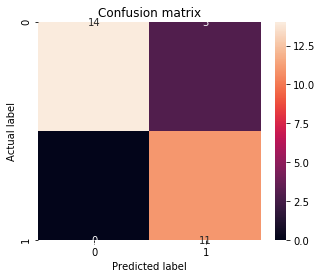

In [15]:
y_pred = model.predict(x_test, batch_size=8)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


predicted_metrics = model.evaluate(x_test, y_test,
                                  batch_size=8, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print(classification_report(y_pred, y_true,
	target_names=lb.classes_))
cm = confusion_matrix(y_pred, y_true)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
